### Imports

In [23]:
from pathlib import Path
import random
import warnings

from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# adapts
from adapts import adapts, adapters
from adapts.icl import iclearner as icl
from adapts.utils.main_script import (
    prepare_data,
    load_moment_model,
    load_moirai_model,
)
from adapts.adapters import (
    # SimpleAutoEncoder,
    # LinearAutoEncoder,
    betaVAE,
    # NormalizingFlow,
    # AENormalizingFlow,
    # JustRevIn,
    # betaLinearVAE,
    # DropoutLinearAutoEncoder,
    # LinearDecoder,
    # LinearEncoder,
    # likelihoodVAE,
    # linearLikelihoodVAE,
)

warnings.filterwarnings("ignore", category=FutureWarning)  # For scikit learn pipeline

### Problem Parameters

In [ ]:
is_fine_tuned: bool = False
forecast_horizon: int = 24
model_name: str = "AutonLab/MOMENT-1-small"  # f"Salesforce/moirai-1.1-R-large"
context_length: int = 512
dataset_name: str = "Illness"
adapter: Optional[str] = None  # "VAE"
seed: int = 13
device: str = "cuda:0"
n_components: int = 7

### set seed

In [6]:
# Set seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load data

In [8]:
# Set dataset name based on forecast horizon if not provided
dataset_name = f"{dataset_name}_pred={forecast_horizon}"

X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name, context_length, forecast_horizon
)
time_series = np.concatenate([X_test, y_test], axis=-1)
train_size = len(X_train)

### Load time series Foundation Model

In [9]:
if "MOMENT" in model_name:
    model = load_moment_model(model_name, forecast_horizon).to(torch.device(device))
    icl_constructor = icl.MomentICLTrainer
elif "moirai" in model_name:
    model = load_moirai_model(model_name, forecast_horizon, context_length).to(
        torch.device(device)
    )
    icl_constructor = icl.MoiraiICLTrainer
else:
    raise ValueError(f"Not supported model: {model_name}")

# Define the corresponding ICLearner class
iclearner = icl_constructor(
    model=model,
    n_features=n_components,
    forecast_horizon=forecast_horizon,
)

### Define adapter

In [14]:
use_revin: bool = True

# Configure adapter
adapter_params = {
    "input_dim": n_features,
    "device": device,
    "context_length": context_length,
    "forecast_horizon": forecast_horizon,
    "n_components": n_components,
    # specific to the chosen adapter
    "use_revin": use_revin,
    "num_layers": 2,
    "hidden_dim": 128,
    "beta": 1.0,
}

adapter_base = betaVAE(**adapter_params).to(device)
# adapter_base = None  # Uncomment this line to choose no adapter
# adapter_base = "pca"  # Uncomment this line to choose pca adapter

# wrap the adapter using the MultiChannelProjector class
adapter = adapters.MultichannelProjector(
    num_channels=n_features,
    new_num_channels=n_components,
    patch_window_size=None,
    base_projector=adapter_base,
    device=device,
    use_revin=use_revin,
    context_length=context_length,
    forecast_horizon=forecast_horizon,
)

### The AdaPTS orchestrator

In [15]:
pca_in_preprocessing: bool = False

adapts_model = adapts.ADAPTS(
    adapter=adapter,
    iclearner=iclearner,
    n_features=n_features,
    n_components=n_components,
    pca_in_preprocessing=pca_in_preprocessing,
)

### Training the adapter

In [18]:
batch_size: int = 32
learning_rate: float = 0.001
n_epochs_fine_tuning: int = 50
n_epochs_adapter: int = 100
log_dir: Path = Path("../logs") / "getting_started"
if not log_dir.exists():
    log_dir.mkdir(parents=True)

if "MOMENT" in model_name:
    # For Moment we first fine tune the linear forecasting head (Linear Probing)
    adapts_model.fine_tune_iclearner(
        X=X_train,
        y=y_train,
        batch_size=batch_size,
        learning_rate=learning_rate,
        verbose=1,
        use_adapter=False,
        n_epochs=n_epochs_fine_tuning,
        seed=seed,
    )

if adapter_base in [None, "pca"]:
    # If no adapter or PCA, we do not need to learn the adapter
    adapts_model.fit_adapter(X=np.concatenate([X_train, X_val], axis=0))
else:
    # Otherwise, we learn the adapter
    adapts_model.adapter_supervised_fine_tuning(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        device=device,
        learning_rate=learning_rate,
        batch_size=batch_size,
        verbose=1,
        n_epochs=n_epochs_adapter,
        log_dir=log_dir,
    )

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/dicl-adapters/src/adapts/icl/iclearner.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]

/mnt/vdb/abenechehab/dicl-adapters/src/adapts/icl/iclearner.py:257: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 23.80it/s]


Epoch 0: Train loss: 0.191, Val loss: 0.259


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 24.34it/s]


Epoch 1: Train loss: 0.192, Val loss: 0.253


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 24.62it/s]


Epoch 2: Train loss: 0.180, Val loss: 0.204


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 24.69it/s]


Epoch 3: Train loss: 0.182, Val loss: 0.249


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 24.71it/s]


Epoch 4: Train loss: 0.178, Val loss: 0.247


Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 24.41it/s]


Epoch 5: Train loss: 0.180, Val loss: 0.238


Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 24.75it/s]


Epoch 6: Train loss: 0.169, Val loss: 0.207


Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 24.63it/s]

Early stopping at epoch 7
Restoring weights from epoch 2



/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  war

Early stopping at epoch 37
Restoring weights from epoch 27


### Test

In [24]:
inference_batch_size: int = 128
n_samples: int = 25  # for sampling the probabilistic adapter

with torch.no_grad():
    mean, _, lb, ub = adapts_model.predict_multi_step(
        X=time_series,
        prediction_horizon=forecast_horizon,
        batch_size=inference_batch_size,
        n_samples=n_samples,
    )

batch on feature 0:: 100%|██████████| 2/2 [00:00<00:00, 102.15it/s]


feature: 100%|██████████| 7/7 [00:00<00:00, 18.98it/s]


### Evaluation metrics

In [25]:
metrics = adapts_model.compute_metrics()
metrics

{'mse': 2.6949036506051884,
 'mae': 1.0554938728157877,
 'scaled_mse': 1.9774839500136392,
 'scaled_mae': 0.9636520935612879,
 'ks': 0.5520098039215687,
 'ece': 0.26707357060471243}

### Plot results

<Figure size 640x480 with 0 Axes>

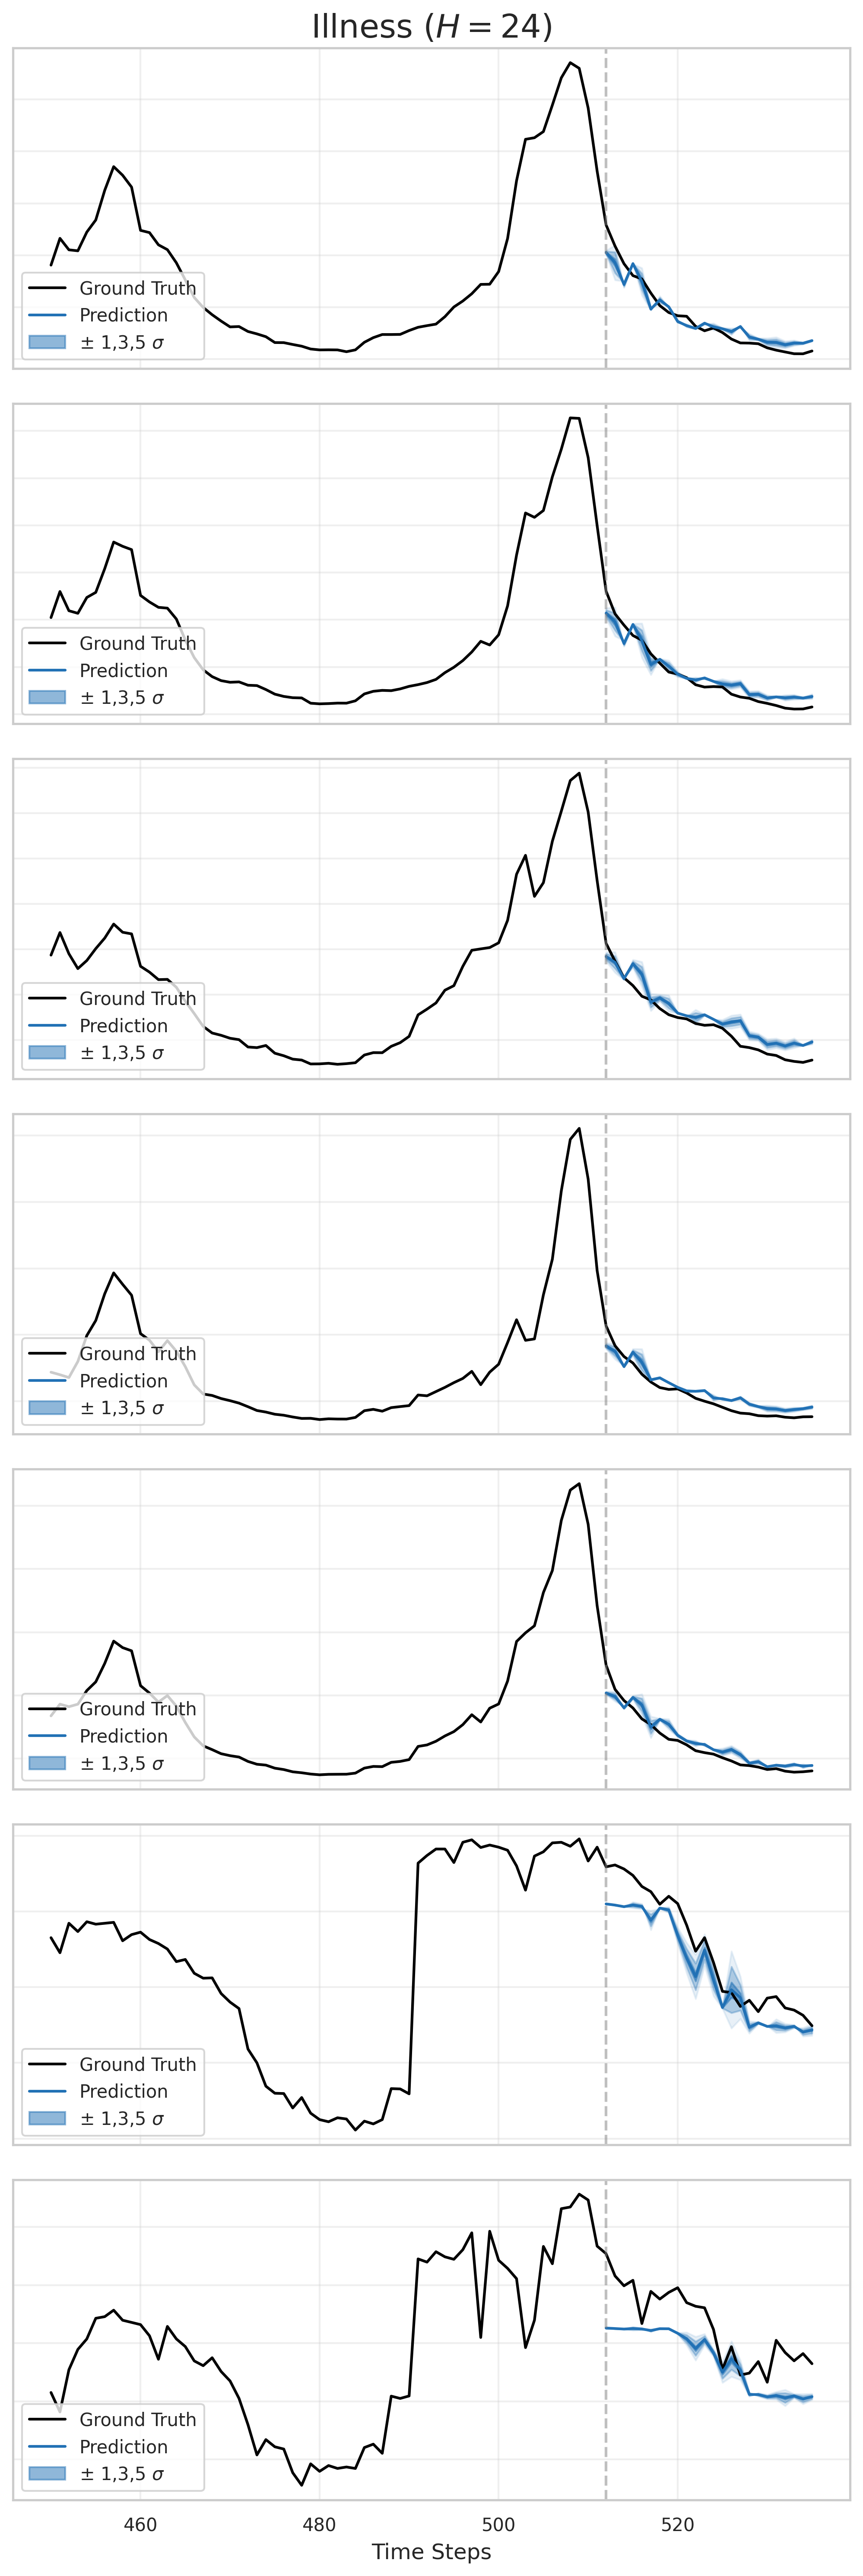

In [31]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

fig, axes = plt.subplots(7, 1, figsize=(7, 20), dpi=300, sharex=True)
axes = axes.flatten()

min_x = 450
sample_idx = 31
for feature in range(n_features):
    ax = axes[feature]

    # Plot actual time series
    ax.plot(
        np.arange(min_x, context_length + forecast_horizon),
        time_series[sample_idx, feature, min_x:],
        label="Ground Truth",
        color="black",
        linewidth=1.5,
    )

    # Plot mean prediction
    ax.plot(
        np.arange(context_length, context_length + forecast_horizon),
        mean[sample_idx, feature],
        label="Prediction",
        color="#2171b5",
        linewidth=1.5,
    )

    # Plot confidence intervals
    ax.fill_between(
        np.arange(context_length, context_length + forecast_horizon),
        lb[sample_idx, feature],
        ub[sample_idx, feature],
        alpha=0.5,
        color="#2171b5",
        label=r"$\pm$ 1,3,5 $\sigma$",
    )
    std = ub[sample_idx, feature] - mean[sample_idx, feature]
    ax.fill_between(
        np.arange(context_length, context_length + forecast_horizon),
        mean[sample_idx, feature] - 3 * std,
        mean[sample_idx, feature] + 3 * std,
        alpha=0.3,
        color="#2171b5",
    )
    ax.fill_between(
        np.arange(context_length, context_length + forecast_horizon),
        mean[sample_idx, feature] - 5 * std,
        mean[sample_idx, feature] + 5 * std,
        alpha=0.1,
        color="#2171b5",
    )

    # Add vertical line to separate context and prediction
    ax.axvline(x=context_length, color="gray", linestyle="--", alpha=0.5)

    # ax.set_ylabel('Value', fontsize=12)
    ax.set_yticklabels([])
    ax.tick_params(axis="both", which="major", labelsize=10)

    # Add legend with better placement
    ax.legend(loc="lower left", frameon=True, fontsize=10)

    # Add grid but make it lighter
    ax.grid(True, alpha=0.3)

    # Tight layout to prevent label clipping
    plt.tight_layout()

    if feature == 0:
        ax.set_title(r"Illness ($H=24$)")

# Customize plot
ax.set_xlabel("Time Steps", fontsize=12)

# Save figure with high resolution
save_fig_path = Path("../figures") / "from_notebooks"
if not save_fig_path.exists():
    save_fig_path.mkdir(parents=True)
plt.savefig(
    str(save_fig_path / "getting_started.pdf"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()